In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gc import collect as collect_garbage
from psutil import virtual_memory

%matplotlib widget

In [2]:
# Imports the data and gives it the index necessary for this file
def import_data(file_name):
    print("Memory before data import: " + str(virtual_memory()[2])+"%")
    
    df = pd.read_csv(file_name)

    observation_time = df["time"][len(df["time"])-1] - df["time"][0]

    center_time = observation_time/2 + df["time"][0]

    df["time"] = df["time"] - center_time

    df["datetime"] = pd.to_datetime(df["time"], unit="s")
    df.set_index(df["datetime"], inplace=True)
    df.drop("datetime", inplace=True, axis=1)

    print("Memory after data import: " + str(virtual_memory()[2])+"%")

    return df

# Returns a time series of the mean RR interval over a sliding window 
def mean_rr(df, offset):
    return(df["interval"].rolling(offset).mean())

# Returns a time series of the SDRR over a sliding window 
def sdrr(df, offset):
    return(df["interval"].rolling(offset).std())

# Returns a time series of the RMSSD over a sliding window
def rmssd(df, offset):
    temp = pd.DataFrame( df["interval"].diff(), index=df.index)
    temp.columns = ["SD"]

    temp["SSD"] = temp["SD"]**2
    temp["MSSD"] = temp["SSD"].rolling(offset).mean()
    temp["RMSSD"] = np.sqrt(temp["MSSD"])

    out = pd.DataFrame.copy(temp["RMSSD"], deep=True)
    out.columns = ["RMSSD"]

    del temp
    collect_garbage()

    return out

# Returns a time series of the pNNk over a sliding window, for your choice of k
def pNN(k, df, offset):
    temp = pd.DataFrame( np.abs(df["interval"].diff()), index=df.index )
    

    # k is typically given in ms, but the abs SD are in seconds
    temp["over k"] = (temp["interval"] > k/1000)

    temp["denominator"] = temp["over k"].rolling(offset).count()
    temp["numerator"] = temp["over k"].rolling(offset).sum()
    temp["pNN"+str(k)] = temp["numerator"]/temp["denominator"]

    out = pd.DataFrame.copy(temp["pNN"+str(k)], deep=True)
    out.columns = ["pNN"+str(k)]

    del temp
    collect_garbage()

    return out

def calc_hrv(df, offset):
    print("Memory before HRV calculations: " + str(virtual_memory()[2])+"%")
    out = pd.DataFrame(df["time"])
    out["Mean RR"] = mean_rr(df, offset)
    out["SDRR"] = sdrr(df, offset)
    out["RMSSD"] = rmssd(df, offset)
    out["pNN20"] = pNN(20, df, offset)
    out["pNN50"] = pNN(50, df, offset)
    print("Memory after HRV calculations: " + str(virtual_memory()[2])+"%")
    return out

def stack_figures(dfs, offset, time_unit="D", indices=None):
    time_unit_dict = {
        "s": 1,
        "min": 60,
        "H": 3600,
        "D": 86400,
        "W": 604800
    }

    print("Memory before drawing figures: " + str(virtual_memory()[2])+"%")

    if indices == None:
        indices = [i for i in range(len(dfs))]

    temp = [dfs[i] for i in indices]

    fig1 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["Mean RR"], linewidth=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Mean RR (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("Mean RR Interval over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig2 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["SDRR"], linewidth=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("SDRR (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("SDRR over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig3 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["RMSSD"], linewidth=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("RMSSD (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("RMSSD over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig4 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["pNN20"], linewidth=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("pNN20 (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("pNN20 over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig4 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["pNN50"], linewidth=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("pNN50 (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("pNN50 over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

def one_figure(dfs, offset, stat, time_unit="D", indices=None):
    time_unit_dict = {
        "s": 1,
        "min": 60,
        "H": 3600,
        "D": 86400,
        "W": 604800
    }

    print("Memory before drawing figures: " + str(virtual_memory()[2])+"%")

    if indices == None:
        indices = [i for i in range(len(dfs))]

    temp = [dfs[i] for i in indices]

    fig1 = plt.figure()
    for df in temp:
        times = df[stat] / time_unit_dict[time_unit]
        plt.plot(times, df[stat], linewidth=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Mean RR (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title(stat + "Interval over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

In [3]:
# Testing it out
dfs = [ import_data("07-pipeline-outputs/03-clean-rr-intervals/rr_intervals_imputed_"+str(i)+".csv") for i in range(1,8)]
offset = "12H"
hrvs = [calc_hrv(df, offset=offset) for df in dfs]

del dfs
collect_garbage()
print(virtual_memory())

Memory before data import: 49.4%
Memory after data import: 50.0%
Memory before data import: 50.0%
Memory after data import: 45.4%
Memory before data import: 45.4%
Memory after data import: 46.3%
Memory before data import: 46.3%
Memory after data import: 46.5%
Memory before data import: 46.5%
Memory after data import: 47.2%
Memory before data import: 47.2%
Memory after data import: 47.9%
Memory before data import: 47.9%
Memory after data import: 48.4%
Memory before HRV calculations: 48.4%
Memory after HRV calculations: 49.2%
Memory before HRV calculations: 49.2%
Memory after HRV calculations: 49.8%
Memory before HRV calculations: 49.8%
Memory after HRV calculations: 50.8%
Memory before HRV calculations: 50.8%
Memory after HRV calculations: 52.1%
Memory before HRV calculations: 52.1%
Memory after HRV calculations: 53.4%
Memory before HRV calculations: 53.4%
Memory after HRV calculations: 54.6%
Memory before HRV calculations: 54.6%
Memory after HRV calculations: 55.9%
svmem(total=12655771

Memory before drawing figures: 53.3%


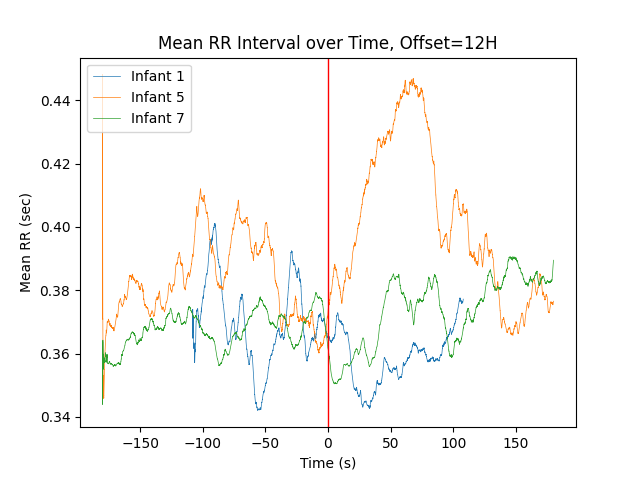

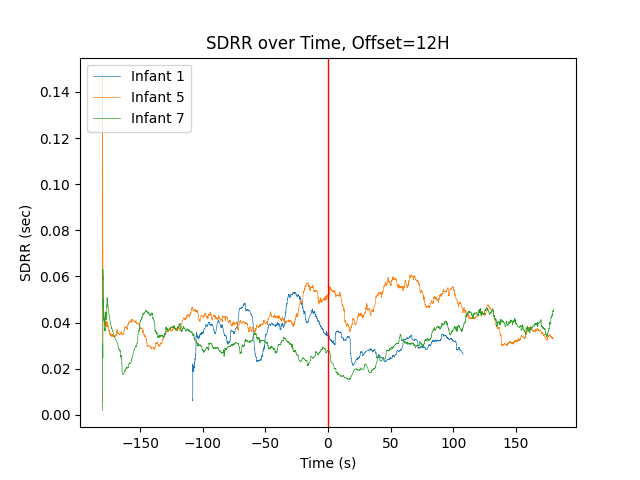

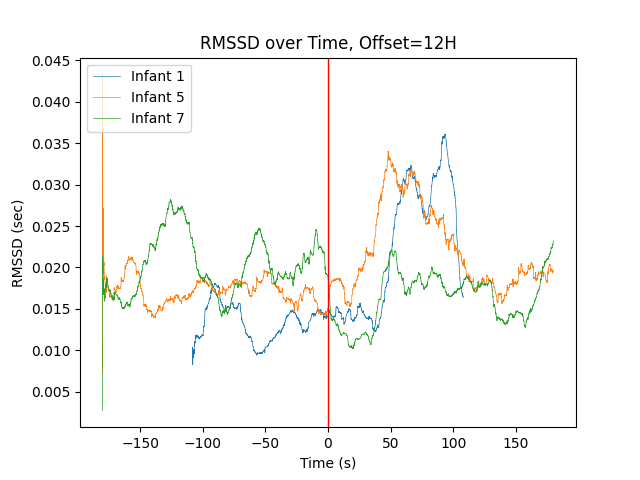

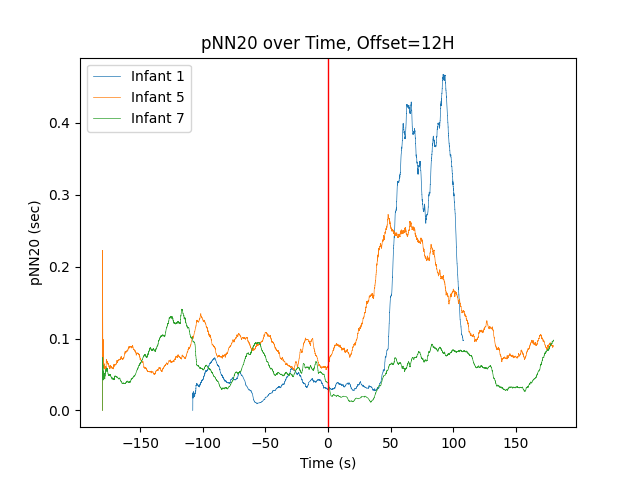

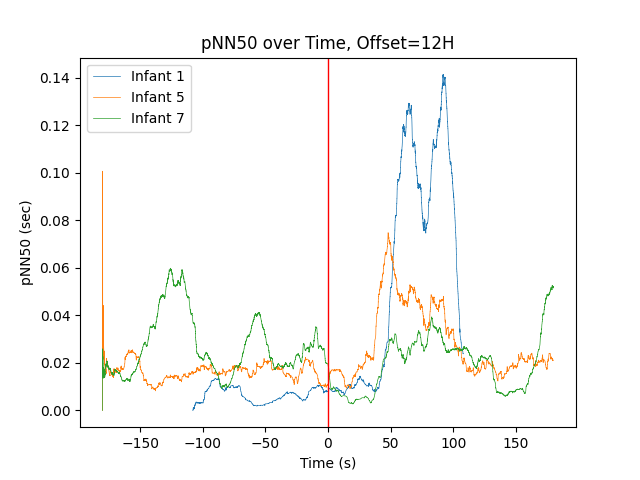

In [4]:
# All of the infants
#stack_figures(hrvs, offset, indices=None, time_unit="H")

# The septic infants only
stack_figures( hrvs, offset, indices=[0,4,6], time_unit="H")

# The non-septic infants only
#stack_figures( hrvs, offset, indices=[1,2,3,5] )

# Individual infants
#stack_figures( hrvs, offset, indices=[0] )
#stack_figures( hrvs, offset, indices=[1] )
#stack_figures( hrvs, offset, indices=[2] )
#stack_figures( hrvs, offset, indices=[3] )
#stack_figures( hrvs, offset, indices=[4] )
#stack_figures( hrvs, offset, indices=[5] )
#stack_figures( hrvs, offset, indices=[6] )


In [6]:
virtual_memory()

svmem(total=12655771648, available=2382143488, percent=81.2, used=10273628160, free=2382143488)